In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pickle


## Analysis without fields

In [2]:
acceptance_ratios = np.loadtxt('no_fields/acceptance_ratio.csv', delimiter=',')
delta_u_list = np.loadtxt('no_fields/energy_changes.csv', delimiter=',')

montecarlo_chains = pd.read_pickle(r'no_fields/montecarlo_chains.pkl')

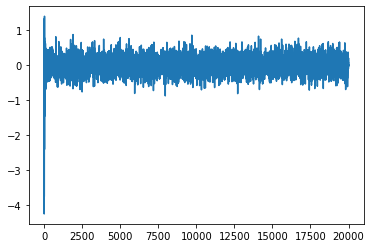

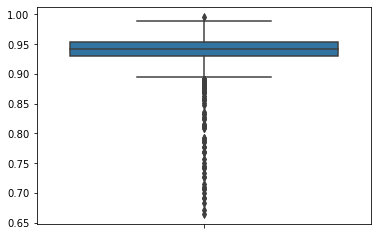

In [3]:
plt.figure()
plt.plot(delta_u_list)

plt.figure()
sns.boxplot(y=acceptance_ratios)

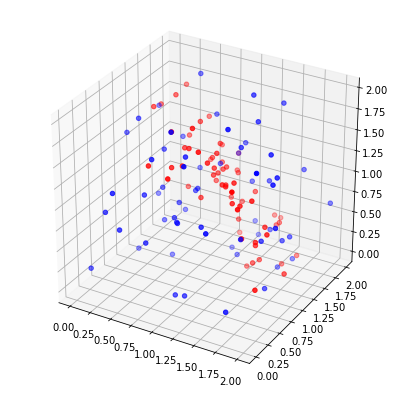

In [4]:
plt.figure(figsize=(7,7))
ax = plt.axes(projection='3d')
ax.scatter3D(montecarlo_chains[0][:,0], montecarlo_chains[0][:,1], montecarlo_chains[0][:,2], c='blue');
ax.scatter3D(montecarlo_chains[-1][:,0], montecarlo_chains[-1][:,1], montecarlo_chains[-1][:,2], c='red');

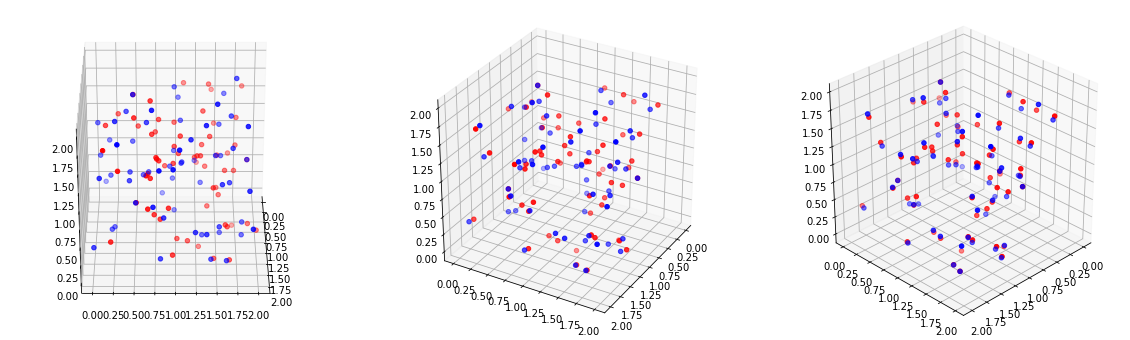

In [5]:
fig = plt.figure(figsize=(20,6))
angles = [0, 30, 45]
i = 1
# plot the first line
for angle in angles:
    # initial chain
    ax = fig.add_subplot(1, 3, i, projection='3d')
    ax.view_init(azim=angle)
    ax.scatter3D(montecarlo_chains[0][:,0], montecarlo_chains[0][:,1], montecarlo_chains[0][:,2], c = 'blue');
    ax.scatter3D(montecarlo_chains[-1][:,0], montecarlo_chains[-1][:,1], montecarlo_chains[-1][:,2], c='red');

    i+=1
    

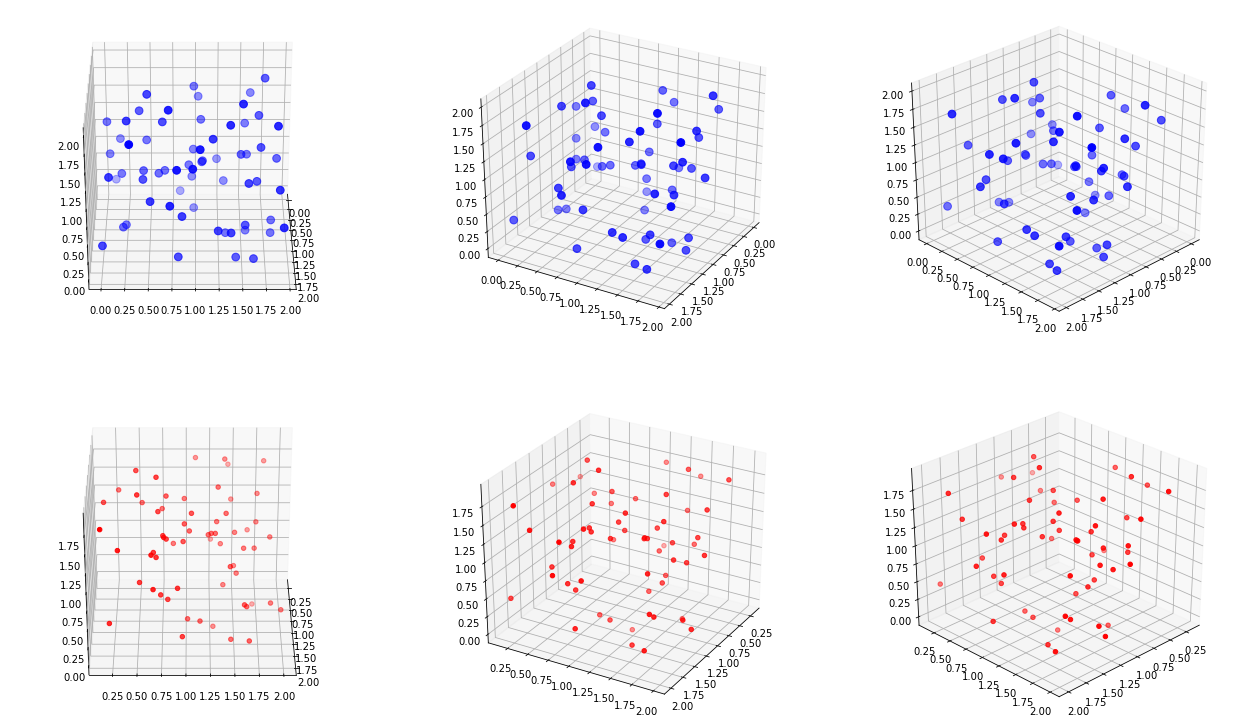

In [6]:
fig = plt.figure(figsize=(22,13))
angles = [0, 30, 45]
i = 1
# plot the first line
for angle in angles:
    # initial chain
    ax = fig.add_subplot(2, 3, i, projection='3d')
    ax.view_init(azim=angle)
    ax.scatter3D(montecarlo_chains[0][:,0], montecarlo_chains[0][:,1], montecarlo_chains[0][:,2], s=60, c='blue');
    i+=1
    
# plot the second line 
for angle in angles:
    # initial chain
    ax = fig.add_subplot(2, 3, i, projection='3d')
    ax.view_init(azim=angle)
    ax.scatter3D(montecarlo_chains[-1][:,0], montecarlo_chains[-1][:,1], montecarlo_chains[-1][:,2], c='red');
    i+=1


# With fields


In [12]:
acceptance_ratios = np.loadtxt('fields/acceptance_ratio.csv', delimiter=',')
delta_u_list = np.loadtxt('fields/energy_changes.csv', delimiter=',')

montecarlo_chains = pd.read_pickle(r'fields/montecarlo_chains.pkl')

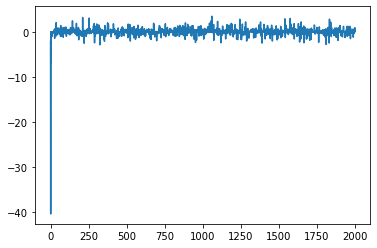

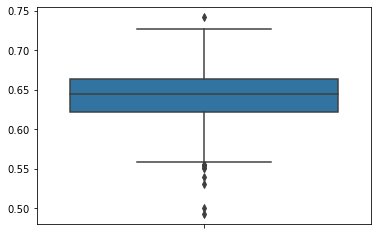

In [13]:
plt.figure()
plt.plot(delta_u_list)

plt.figure()
sns.boxplot(y=acceptance_ratios)

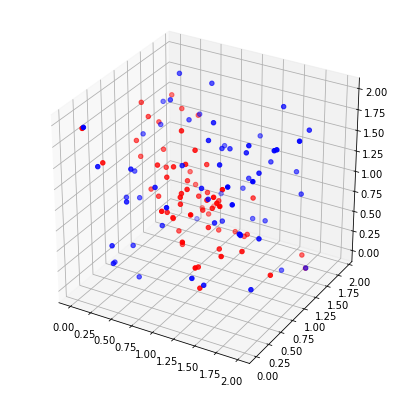

In [14]:
plt.figure(figsize=(7,7))
ax = plt.axes(projection='3d')
ax.scatter3D(montecarlo_chains[0][:,0], montecarlo_chains[0][:,1], montecarlo_chains[0][:,2], c='blue');
ax.scatter3D(montecarlo_chains[-1][:,0], montecarlo_chains[-1][:,1], montecarlo_chains[-1][:,2], c='red');

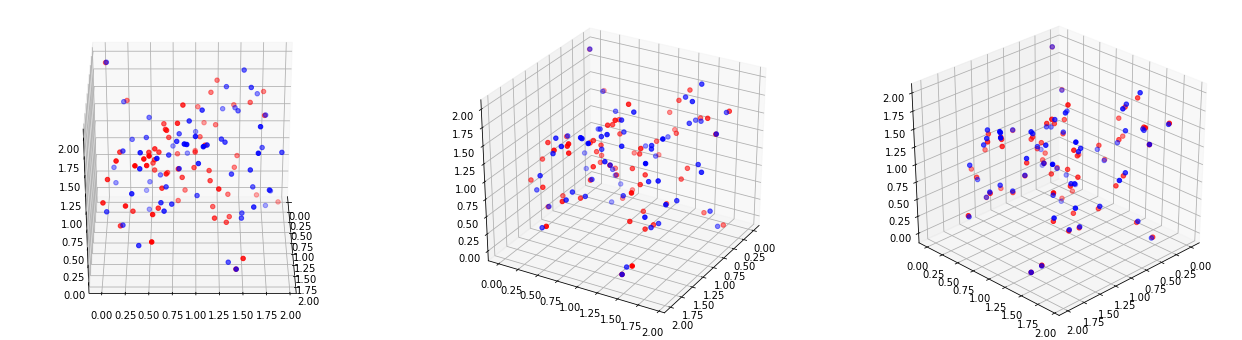

In [15]:
fig = plt.figure(figsize=(22,6))
angles = [0, 30, 45]
i = 1
# plot the first line
for angle in angles:
    # initial chain
    ax = fig.add_subplot(1, 3, i, projection='3d')
    ax.view_init(azim=angle)
    ax.scatter3D(montecarlo_chains[0][:,0], montecarlo_chains[0][:,1], montecarlo_chains[0][:,2], c = 'blue');
    ax.scatter3D(montecarlo_chains[-1][:,0], montecarlo_chains[-1][:,1], montecarlo_chains[-1][:,2], c='red');

    i+=1
    

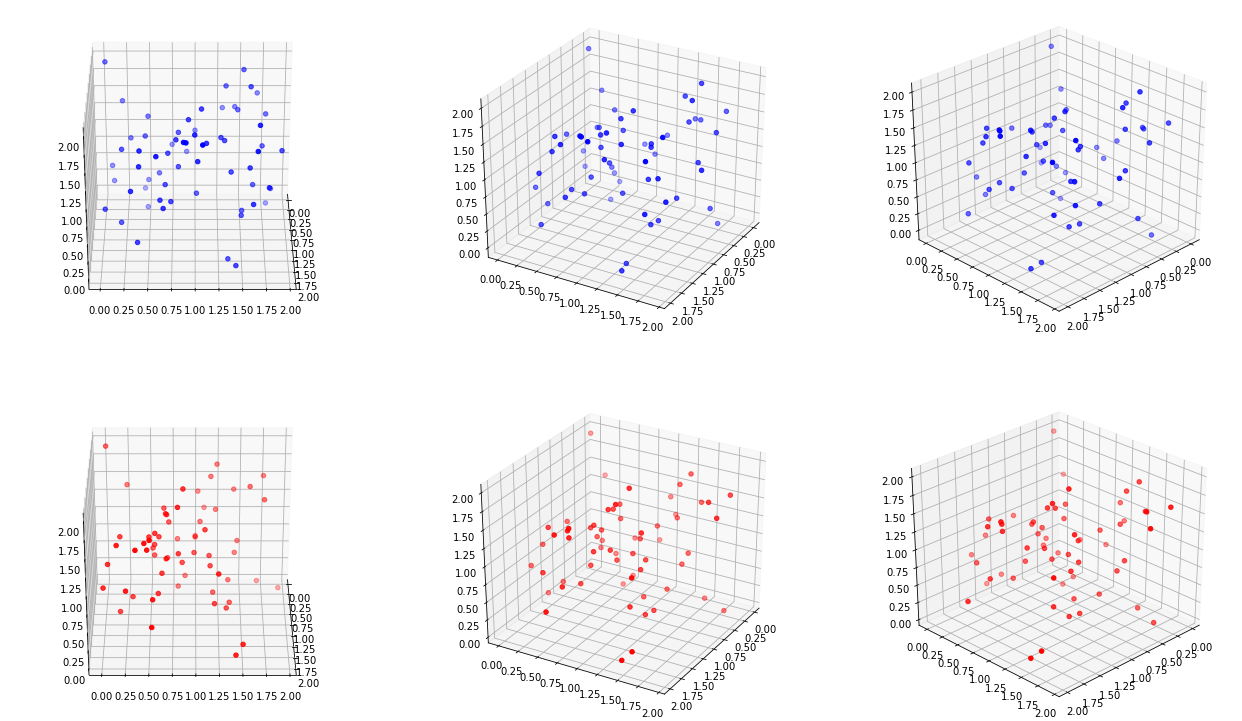

In [16]:
fig = plt.figure(figsize=(22,13))
angles = [0, 30, 45]
i = 1
# plot the first line
for angle in angles:
    # initial chain
    ax = fig.add_subplot(2, 3, i, projection='3d')
    ax.view_init(azim=angle)
    ax.scatter3D(montecarlo_chains[0][:,0], montecarlo_chains[0][:,1], montecarlo_chains[0][:,2], c='blue');
    i+=1
    
# plot the second line 
for angle in angles:
    # initial chain
    ax = fig.add_subplot(2, 3, i, projection='3d')
    ax.view_init(azim=angle)
    ax.scatter3D(montecarlo_chains[-1][:,0], montecarlo_chains[-1][:,1], montecarlo_chains[-1][:,2], c='red');
    i+=1
